In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [121]:
def split_table(music_table):
    labels = music_table.select_dtypes('object')
    labels['release date'] = pd.to_datetime(labels['release date'],errors='coerce')
    music_table[['key','mode','time_signature']] = music_table[['key','mode','time_signature']].astype('object')
    features = music_table.drop(labels,1)
    return features, labels

In [136]:
exid_feats,exid_labels = split_table(pd.read_csv('exid-features.csv'))
exid_feats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 13 columns):
acousticness        99 non-null float64
danceability        99 non-null float64
duration_ms         99 non-null int64
energy              99 non-null float64
instrumentalness    99 non-null float64
key                 99 non-null object
liveness            99 non-null float64
loudness            99 non-null float64
mode                99 non-null object
speechiness         99 non-null float64
tempo               99 non-null float64
time_signature      99 non-null object
valence             99 non-null float64
dtypes: float64(9), int64(1), object(3)
memory usage: 10.1+ KB


C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Time to break down these 13 features. I'll start with what I understand. 

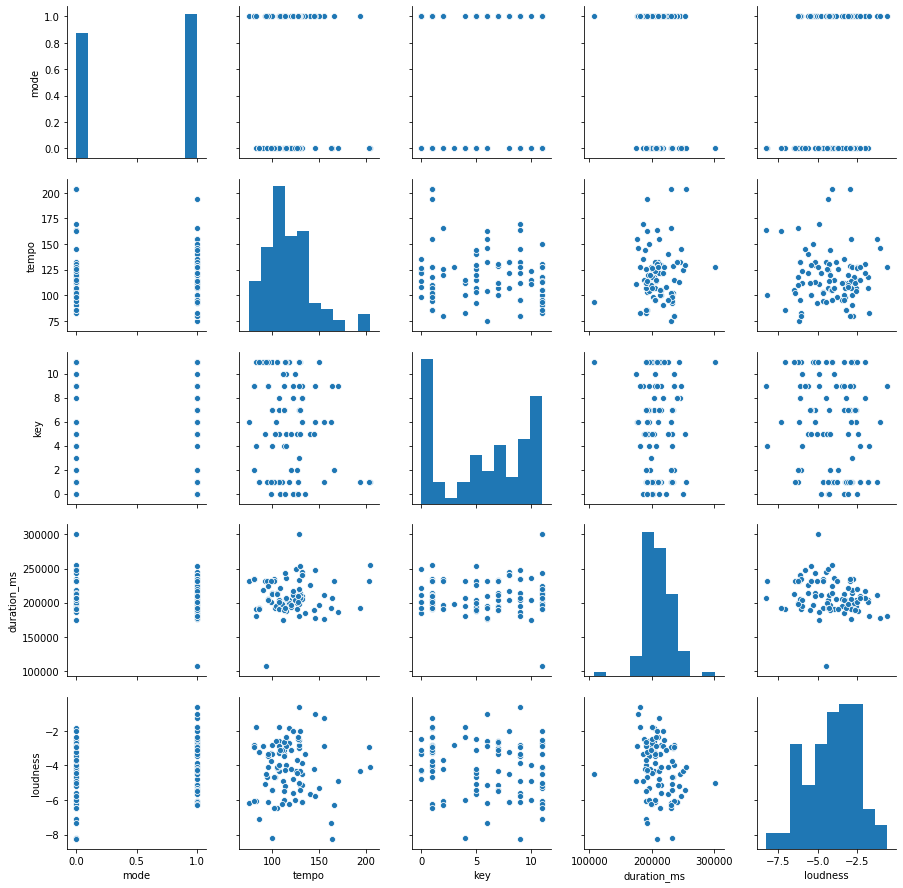

In [123]:
from seaborn import pairplot
pairplot(exid_feats[['mode','tempo','key','duration_ms','loudness']])

Mode indicates major or minor, and EXID has slightly more major songs (reasonable). Nearly all their songs are in 4/4 (unreasonable). Tempo, duration, and loudness are all roughly normally spread (reasonable). Key is spread out with more representation at C than C# or even D (reasonable). 

Text(0.5, 1.0, 'Time Signature (EXID)')

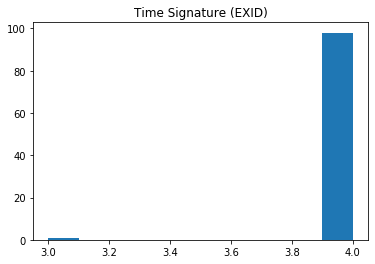

In [124]:
plt.hist('time_signature',data=exid_feats)
plt.title('Time Signature (EXID)')

In [125]:
exid_labels[(exid_feats['time_signature']==3)]

,song title,album title,album group,album type,release date,artist name
25,Are You Hungry? [Jeonghwa & Hyelin Solo],Street,album,album,2016-06-01,EXID


In [137]:
exid_feats = exid_feats.replace(3,4)
exid_feats[(exid_feats['time_signature']==3)]

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence


I want to understand the outliers in the song length as pop song length should be very consistent.

In [138]:
print(exid_labels[(exid_feats['duration_ms']<1.5e5)])
print(exid_labels[(exid_feats['duration_ms']>2.5e5)])

   song title album title album group album type release date artist name
83       I DO       HOLLA      single     single   2012-02-16        EXID
                 song title  album title album group album type release date  \
36  Every Night - Version 2      AH YEAH       album      album   2015-04-14   
65    Foolish (Hyelin Solo)    Full Moon      single     single   2017-11-08   
82  I Feel Good (R.T Remix)  HIPPITY HOP      single     single   2012-08-13   

   artist name  
36        EXID  
65        EXID  
82        EXID  


The only real outlier here is the longest song which is a remix. Let's drop anything over 4:30 in length.

In [184]:
def length_mask(df):
    length_mask = (df['duration_ms']>2.7e5)|(df['duration_ms']<1.5e5)
    return length_mask
exid_mask = length_mask(exid_feats)
exid_labels = exid_labels.drop(exid_feats[exid_mask].index)
exid_feats = exid_feats.drop(exid_feats[exid_mask].index)
exid_labels[(exid_feats['duration_ms']>2.5e5)]

,song title,album title,album group,album type,release date,artist name
36,Every Night - Version 2,AH YEAH,album,album,2015-04-14,EXID
65,Foolish (Hyelin Solo),Full Moon,single,single,2017-11-08,EXID


In [130]:
print(exid_feats.shape)
exid_labels.duplicated(subset=['song title']).sum()

(98, 13)


7

In [65]:
exid_labels[exid_labels.duplicated(subset=['song title'])]

,song title,album title,album group,album type,release date,artist name
38,TROUBLE,TROUBLE,single,single,2019-02-27,EXID
39,TROUBLE,TROUBLE,single,single,2019-01-30,EXID
44,VAPORIZE YOURSELF!,UP&DOWN ([JAPANESE VERSION] SPECIAL EDITION),single,single,2018-08-22,EXID
48,A Sul Hae,[Re:flower] PROJECT #4,single,single,2018-06-19,EXID
56,Don't Want a Drive,[Re:flower] PROJECT #2,single,single,2018-02-13,EXID
68,How Why,Eclipse,single,single,2017-04-10,EXID
73,Up & Down,Up & Down,single,single,2014-08-28,EXID


Because there are not many duplicates and it's not like Up & Down has 50 rereleases yet, I'll not bother with removing duplicates for now. 

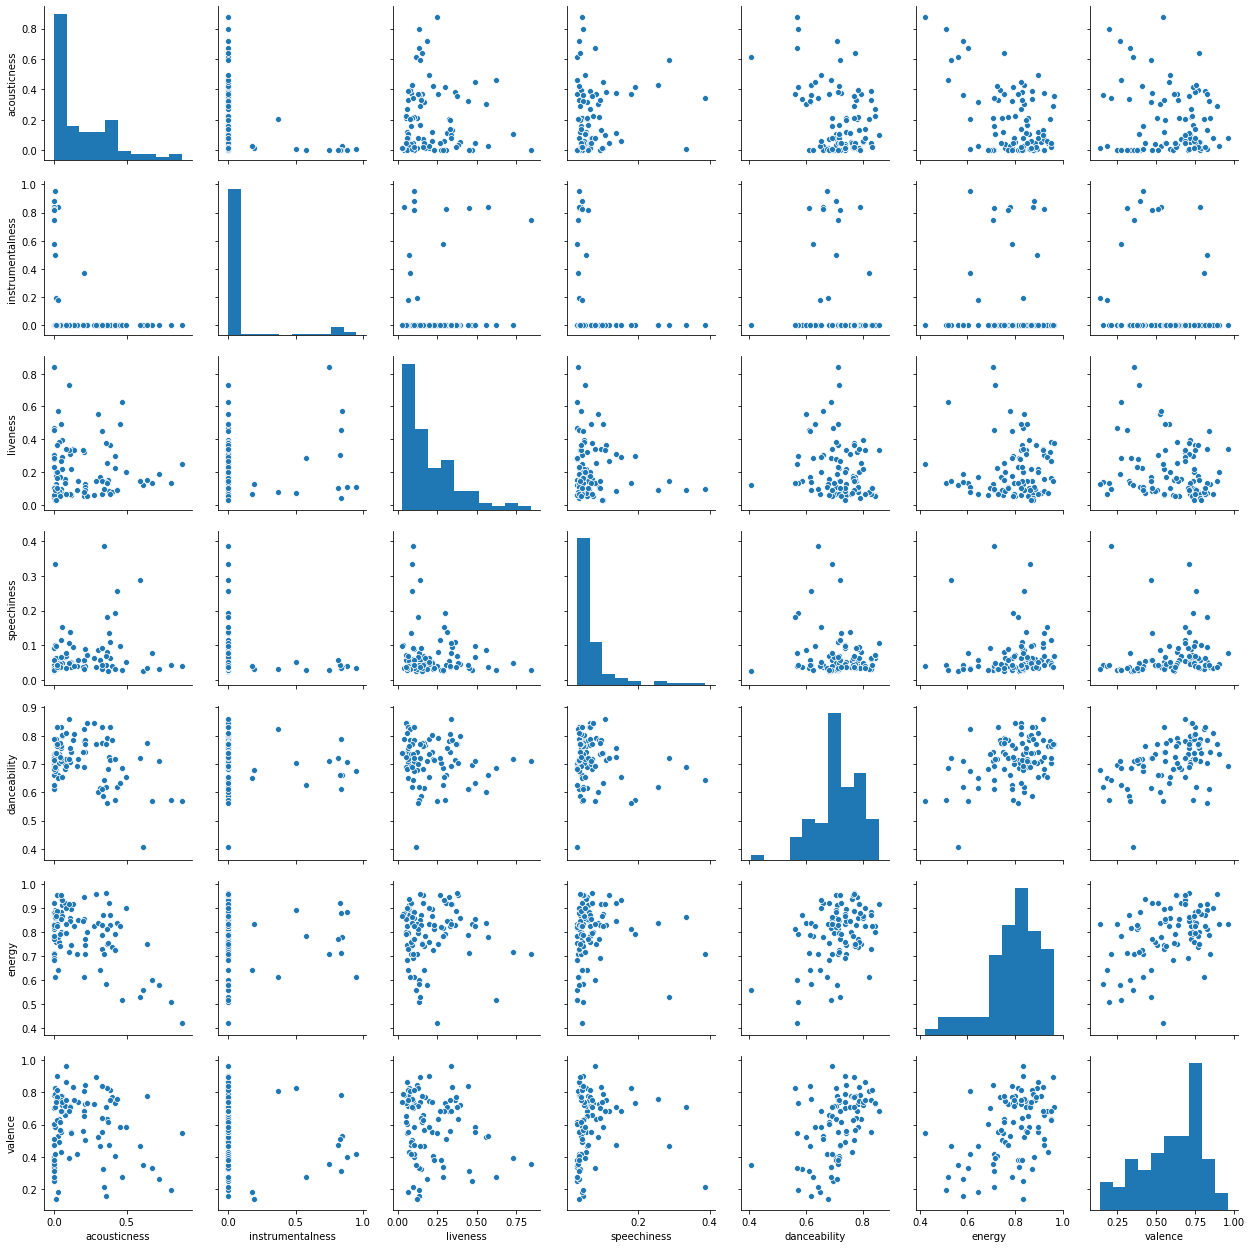

In [75]:
pairplot(exid_feats[['acousticness','instrumentalness','liveness','speechiness','danceability','energy','valence']])

The rest are Spotify's calculated features. Acousticness is dominated at zero, indicating heavy electronic presence. Danceability and energy are roughly distributed around 70 and 80%, respectively. Instrumentalness is zero, indicating heavy vocal presence. Speechiness is mostly zero, indicating very little spoken word elements. Liveness is skewed right and valence is skewed left. Respectively, these indicate high likelihood of studio mastering and uplifting mood. 

Let's see how danceability, energy, and valence relate to the more deterministic features.

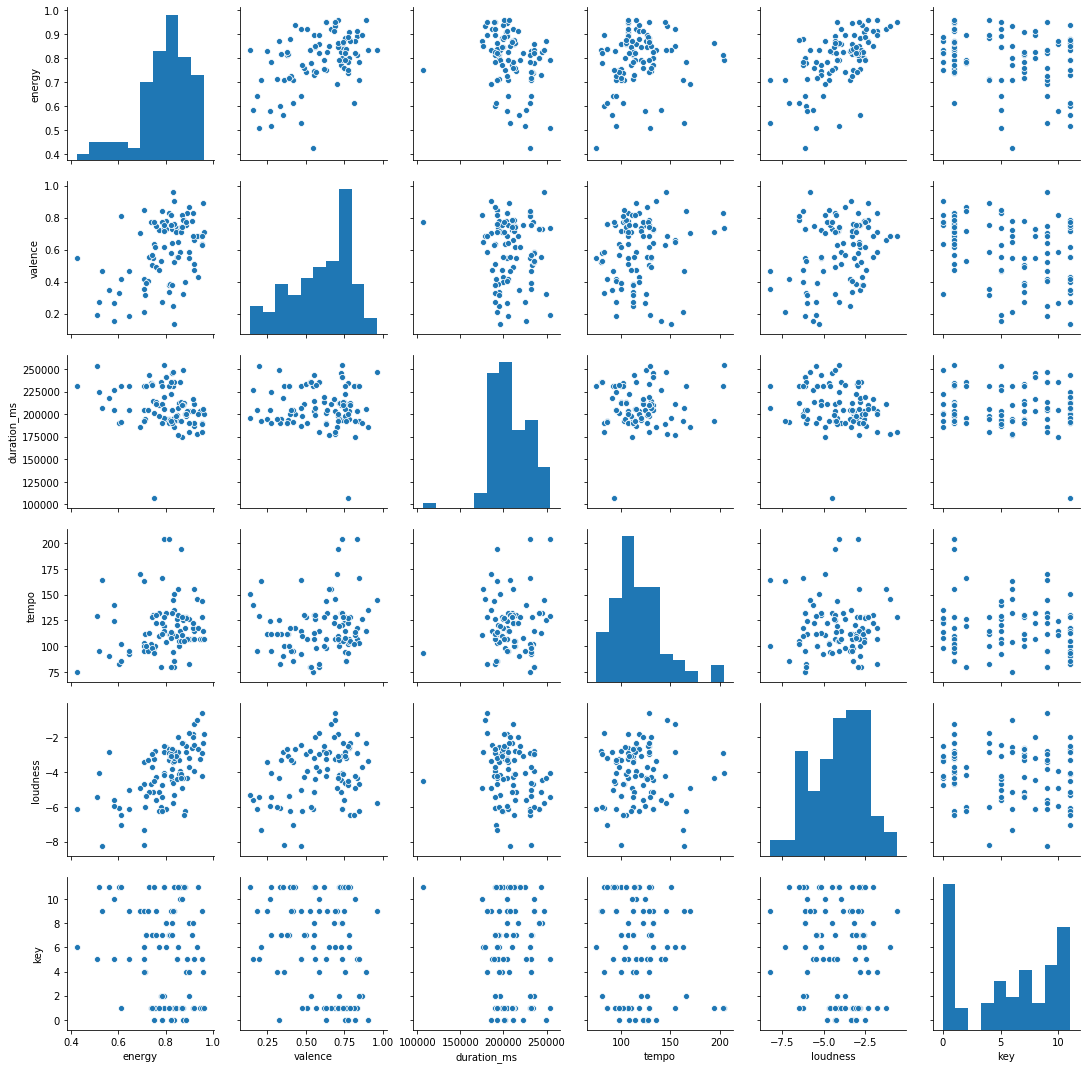

In [135]:
pairplot(exid_feats[['energy','valence','duration_ms','tempo','loudness','key']])

LOL The fastest song is in C! Tempo is centered around 120, as expected. Song length is consistent, also as expected.  I notice longer songs tend to have lower energy. Off my head, I'd name "Every Night" as an example, as it's slower and longer. Energy is related to loudness in something resembling sqrt(x). Beyond that, I'd say these are not strong correlations. Valence and energy seem to have a roughly linear relationship. Dimensional reduction could be useful.

Text(0, 0.5, 'Squared Energy')

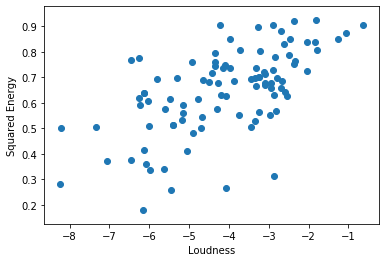

In [142]:
plt.scatter(exid_feats.loudness,np.square(exid_feats.energy))
plt.xlabel('Loudness')
plt.ylabel('Squared Energy')

Now let's load a new database to compare EXID with some contemporaries:
SISTAR, BESTie, HELLOVENUS, Girls Day, and Apink. Let's called this list of contemporary girl groups 'cgg'. I'll do a similar analysis on this dataset and see if EXID stands out in any of the existing features. If not, I could add features but it would also suggest that there are too many similarities with these features. 

In [380]:
cgg,cgg_labels = split_table(pd.read_csv('exid-comparison-features.csv'))
cgg.shape

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(573, 14)

In [381]:
cgg_mask = length_mask(cgg)
cgg_labels = cgg_labels.drop(cgg[cgg_mask].index)
cgg = cgg.drop(cgg[cgg_mask].index)
cgg_labels[cgg['duration_ms']>2.5e5]

,album group,album title,album type,artist name,release date,song title
23,album,Summer Special 'Loving U',album,SISTAR,2012-06-28,How dare you (Demicat Remix)
57,single,Special Album ‘SWEET & SOUR’,single,SISTAR,2014-08-26,Touch My Body (Glen Check Remix)
82,album,Mini Album Digital Repackage,album,BESTie,2014-08-29,Like a star
90,album,Hot Baby,album,BESTie,2014-07-28,Like a star
102,single,Like a star,single,BESTie,2014-07-11,Like a star
176,album,GIRL'S DAY EVERYDAY no. 5,album,Girl's Day,2017-03-27,Kumbaya (Come by here) 소진 Solo Version
218,album,기대,album,Girl's Day,2013-03-14,너 한눈 팔지마! Remix Club Version
260,single,Girl's Day Party no. 4,single,Girl's Day,2011-09-02,"너, 한눈 팔지마! DJ Stereo Club Mix Version"
336,appears_on,City Hunter (Original Television Soundtrack),compilation,Girl's Day,2017-01-19,Always Look At You
337,appears_on,City Hunter (Original Television Soundtrack),compilation,Girl's Day,2017-01-19,So Goodbye


C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


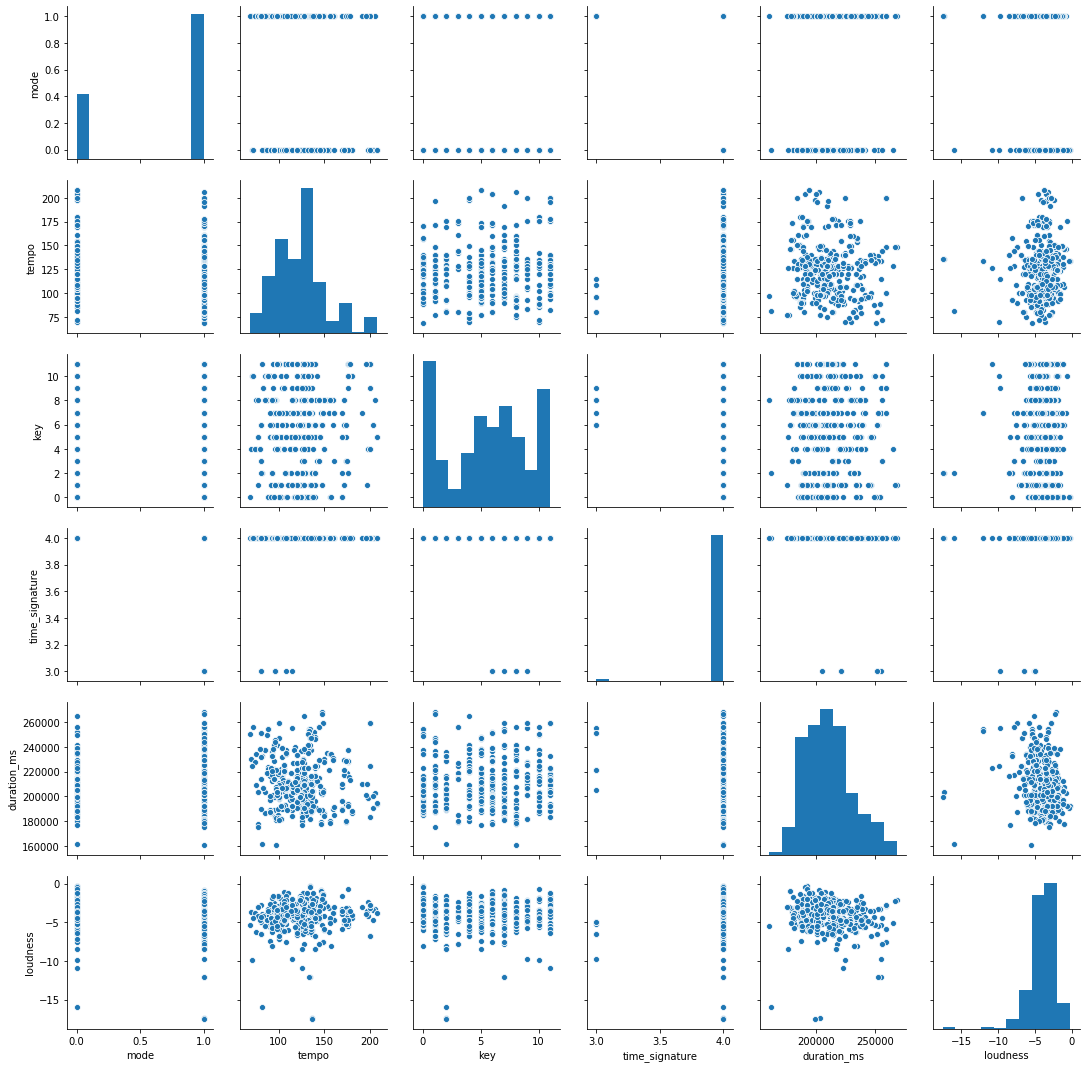

In [331]:
pairplot(cgg[['mode','tempo','key','time_signature','duration_ms','loudness']])

Here, we see much stronger representation in major mode songs. Tempo is centered around 120 as expected with a skew right indicating many ballads. Key shows D is underrepresented again for some reason. Loudness is consistent with few outliers. Duration is roughly normal with a tail meaning longer songs. Not any correlation between these features, as I would expect.

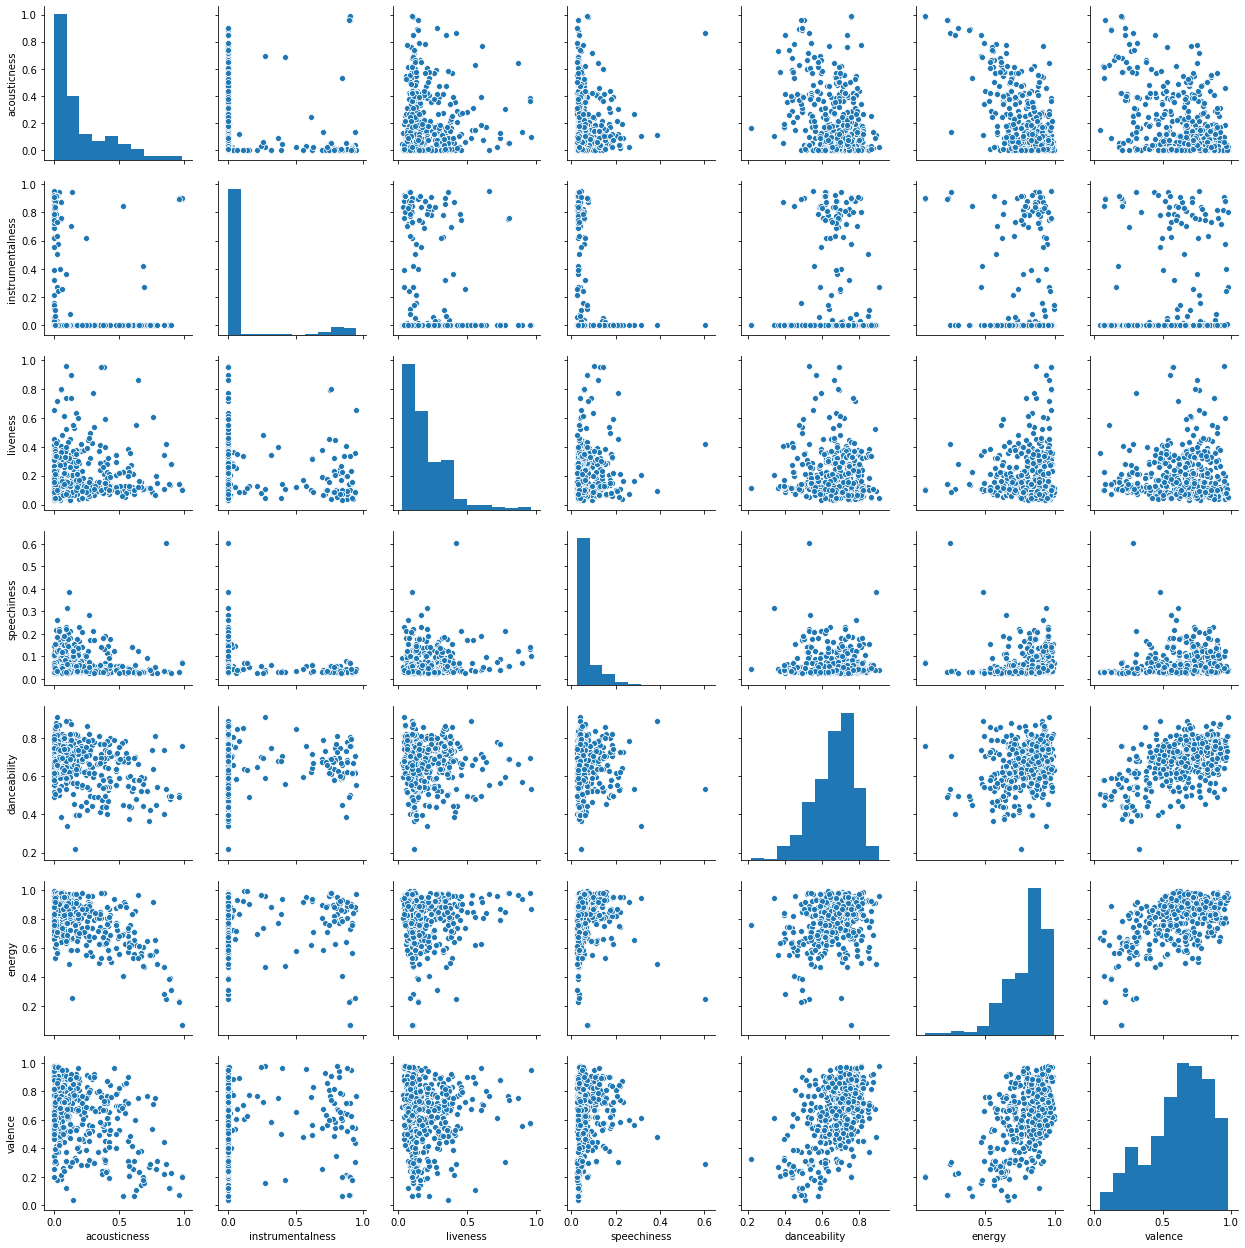

In [191]:
pairplot(cgg[['acousticness','instrumentalness','liveness','speechiness','danceability','energy','valence']])

From this, it looks like the features are similar with those of EXID. High valence, energy, danceability. Low speechiness, liveness, instrumentalness, and acousticness.

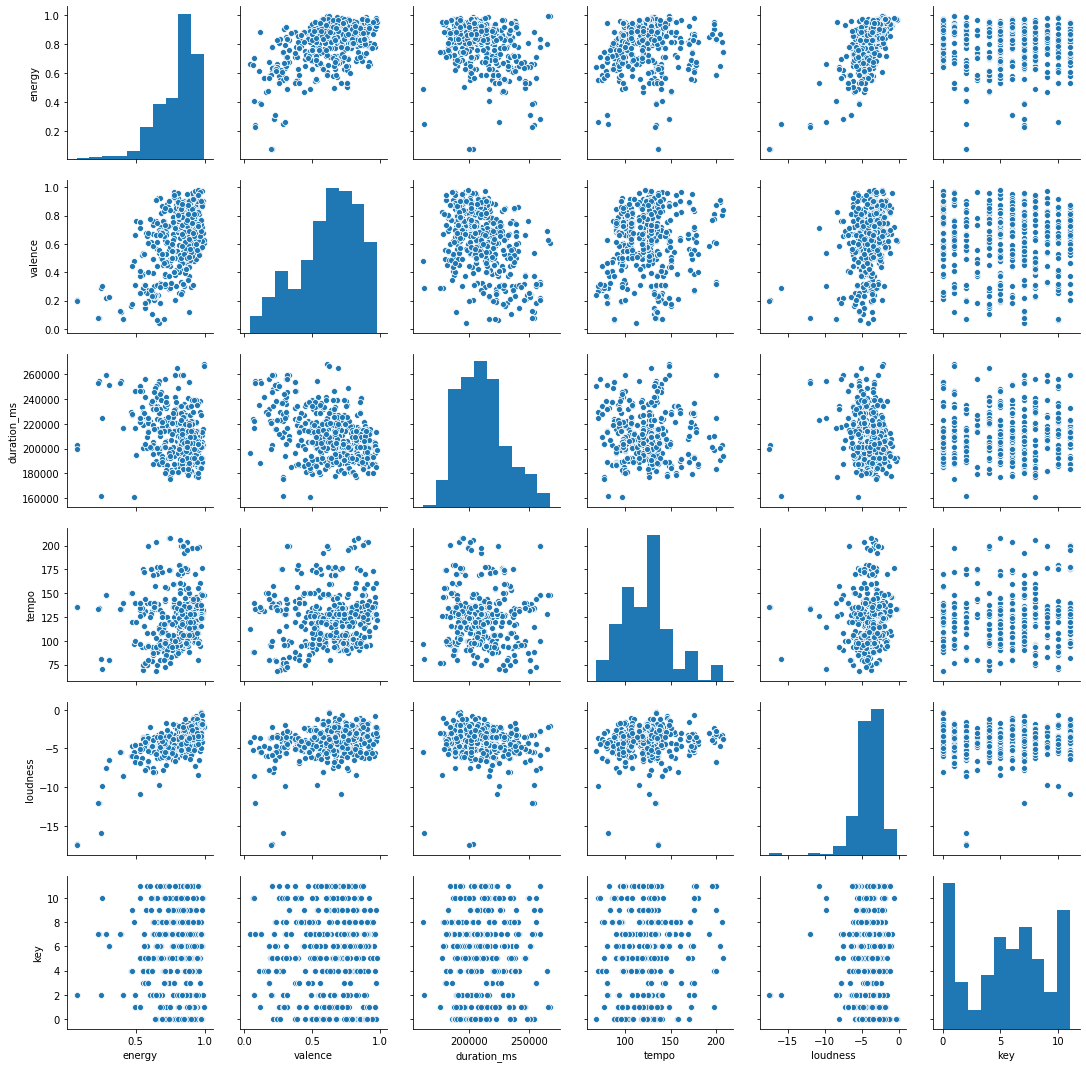

In [192]:
pairplot(cgg[['energy','valence','duration_ms','tempo','loudness','key']])

It looks like the loudness vs. energy relationship is different in this distribution, either linear or quadratic. It also looks like energy and valence have a quadratic relationship.

Text(0.5, 0, 'Energy')

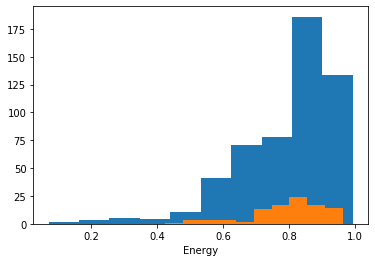

In [197]:
plt.hist('energy',data=cgg)
plt.hist('energy',data=exid_feats)
plt.xlabel('Energy')

Text(0.5, 0, 'Loudness')

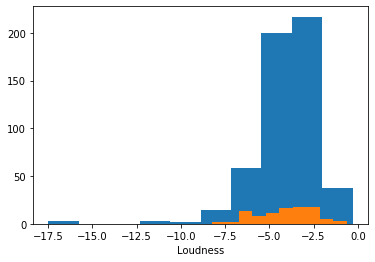

In [198]:
plt.hist('loudness',data=cgg)
plt.hist('loudness',data=exid_feats)
plt.xlabel('Loudness')

Text(0.5, 0, 'Valence')

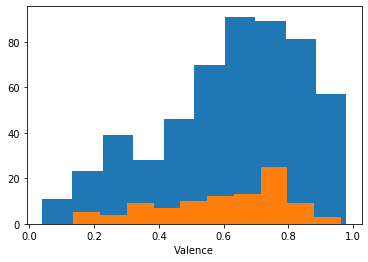

In [207]:
plt.hist('valence',data=cgg)
plt.hist('valence',data=exid_feats)
plt.xlabel('Valence')

Text(0.5, 0, 'Danceability')

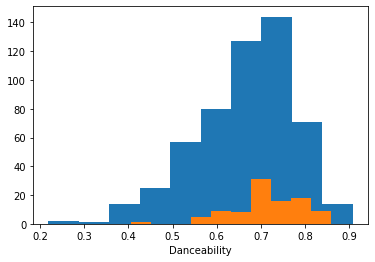

In [211]:
plt.hist('danceability',data=cgg)
plt.hist('danceability',data=exid_feats)
plt.xlabel('Danceability')

Text(0, 0.5, 'Energy')

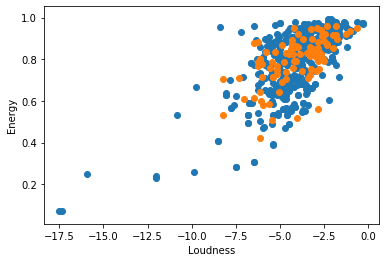

In [203]:
plt.scatter('loudness','energy',data=cgg)
plt.scatter('loudness','energy',data=exid_feats)
plt.xlabel('Loudness')
plt.ylabel('Energy')

Text(0, 0.5, 'Valence')

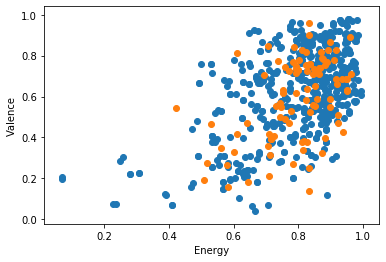

In [206]:
plt.scatter('energy','valence',data=cgg)
plt.scatter('energy','valence',data=exid_feats)
plt.xlabel('Energy')
plt.ylabel('Valence')

Text(0, 0.5, 'Valence')

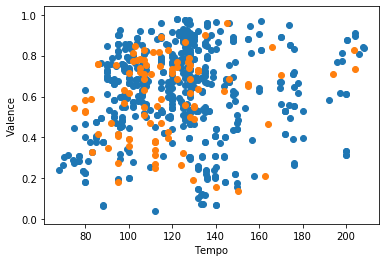

In [209]:
plt.scatter('tempo','valence',data=cgg)
plt.scatter('tempo','valence',data=exid_feats)
plt.xlabel('Tempo')
plt.ylabel('Valence')

I don't have a lot of confidence that ML can separate EXID from these groups. There's a lot of overlap! Some subtle differences... the only not-subtle one is mode. Still, let's see what we can do. 

I'll assign a 'rating' of 1 for EXID and 0 for the others, turning this into a binary classification problem. I have 536 songs by CGG and 97 songs by EXID. It's unbalanced, but hopefully not too much. I can use SMOTE to make it balanced.

In [382]:
exid_labels['rating']=1
cgg_labels['rating']=0
sum_feats = pd.concat([exid_feats,cgg],0).reset_index(drop=True).drop('0',1)
sum_labels = pd.concat([exid_labels,cgg_labels],0).reset_index(drop=True)

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [383]:
sum_feats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 633 entries, 0 to 632
Data columns (total 14 columns):
acousticness        632 non-null float64
danceability        632 non-null float64
duration_ms         632 non-null float64
energy              632 non-null float64
instrumentalness    632 non-null float64
key                 632 non-null object
liveness            632 non-null float64
loudness            632 non-null float64
mode                632 non-null object
rating              97 non-null float64
speechiness         632 non-null float64
tempo               632 non-null float64
time_signature      632 non-null object
valence             632 non-null float64
dtypes: float64(11), object(3)
memory usage: 69.3+ KB


In [389]:
ind=pd.isnull(sum_feats).any(1).nonzero()[0]
sum_feats = sum_feats.drop(list(ind),0).reset_index(drop=True)
sum_labels = sum_labels.drop(list(ind),0).reset_index(drop=True)
sum_feats.isna().sum()

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  """Entry point for launching an IPython kernel.


acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
rating              0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64

Rating is our label and it's separated with the artist names. I'll define that variable as 'y'. 'X' will be the matrix of all features. I'll use a pipeline to scale the numerical features and transform the categorical ones with one hot encoding. Then, I will classify the data. Let's go!

In [322]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

In [391]:
y = sum_labels['rating']
X = sum_feats.drop('rating',1)

In [392]:
X.isna().sum()

acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64

In [393]:
yX = pd.concat([X,y],1)
yX.corr()['rating'].sort_values()

acousticness       NaN
danceability       NaN
duration_ms        NaN
energy             NaN
instrumentalness   NaN
liveness           NaN
loudness           NaN
speechiness        NaN
tempo              NaN
valence            NaN
rating             NaN
Name: rating, dtype: float64

Yeah, not feeling too confident about this. There's only a slight correlation between 'rating' and danceability, meaning this will be a confusing model.

In [324]:
num_process = Pipeline([('scaler',StandardScaler())])
cat_process = Pipeline([('ohe',OneHotEncoder())])
processor = ColumnTransformer([('num',num_process,X.select_dtypes('float64').columns),
                                ('cat',cat_process,X.select_dtypes('object').columns)
                              ])
model = Pipeline([('processor',processor),
                 ('classifier',GradientBoostingClassifier())])

In [387]:
x_train, x_test, y_train, y_test = train_test_split(X,y)

model.fit(x_train,y_train)
cv = cross_validate(model,x_test,y_test,scoring='f1',cv=12)
print(cv['test_score'],confusion_matrix(y_test,model.predict(x_test)))

ValueError: Input contains NaN